[Соревнование](https://inclass.kaggle.com/c/beeline-credit-scoring-competition-3)


Признаки клиентов банка:
- Age - возраст (вещественный)
- Income - месячный доход (вещественный)
- BalanceToCreditLimit - отношение баланса на кредитной карте к лимиту по кредиту (вещественный)
- DIR - Debt-to-income Ratio (вещественный)
- NumLoans - число заемов и кредитных линий
- NumRealEstateLoans - число ипотек и заемов, связанных с недвижимостью (натуральное число)
- NumDependents - число членов семьи, которых содержит клиент, исключая самого клиента (натуральное число)
- Num30-59Delinquencies - число просрочек выплат по кредиту от 30 до 59 дней (натуральное число)
- Num60-89Delinquencies - число просрочек выплат по кредиту от 60 до 89 дней (натуральное число)
- Delinquent90 - были ли просрочки выплат по кредиту более 90 дней (бинарный) - имеется только в обучающей выборке

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pydot
import sklearn
from graphviz import Source

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

def quality_report(prediction, actual):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}".format(
        accuracy_score(prediction, actual),
        precision_score(prediction, actual),
        recall_score(prediction, actual),
        f1_score(prediction, actual)
    ))
    

def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
    auc_score = roc_auc_score(y_test, prob_prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

In [4]:
import seaborn as sns

**Загружаем данные.**

In [6]:
train_df = pd.read_csv('./../data/credit_scoring_train.csv', index_col='client_id')
test_df = pd.read_csv('./../data/credit_scoring_test.csv', index_col='client_id')

In [7]:
train_df.shape

(75000, 10)

In [8]:
train_df.head()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
client_id,,,,,,,,,,
0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028,0
1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679,0
2,2206.731199,55.5,21,1,NaN,1,0,NaN,0.348227,0
3,886.132793,55.3,3,0,0.0,0,0,NaN,0.971930,0
4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350,0


**Посчитаем число пропусков в каждом признаке.**

In [9]:
train_df.isnull().sum()

DIR                          0
Age                          0
NumLoans                     0
NumRealEstateLoans           0
NumDependents             1916
Num30-59Delinquencies        0
Num60-89Delinquencies        0
Income                   14847
BalanceToCreditLimit         0
Delinquent90                 0
dtype: int64

In [10]:
test_df.isnull().sum()

DIR                          0
Age                          0
NumLoans                     0
NumRealEstateLoans           0
NumDependents             2008
Num30-59Delinquencies        0
Num60-89Delinquencies        0
Income                   14884
BalanceToCreditLimit         0
dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df.drop(['Delinquent90'], axis=1), 
    train_df['Delinquent90'], 
    test_size=0.20, 
    random_state=42, 
    stratify=train_df['Delinquent90']
)

In [12]:
y_train.value_counts(normalize=True)

Delinquent90
0    0.933167
1    0.066833
Name: proportion, dtype: float64

In [13]:
y_test.value_counts(normalize=True)

Delinquent90
0    0.933133
1    0.066867
Name: proportion, dtype: float64

**Заменим пропуски медианными значениями.**

In [14]:
X_train['NumDependents'].fillna(X_train['NumDependents'].median(), inplace=True)
X_train['Income'].fillna(X_train['Income'].median(), inplace=True)

X_test['NumDependents'].fillna(X_test['NumDependents'].median(), inplace=True)
X_test['Income'].fillna(X_test['Income'].median(), inplace=True)

In [15]:
test_df['NumDependents'].fillna(X_train['NumDependents'].median(), inplace=True)
test_df['Income'].fillna(X_train['Income'].median(), inplace=True)

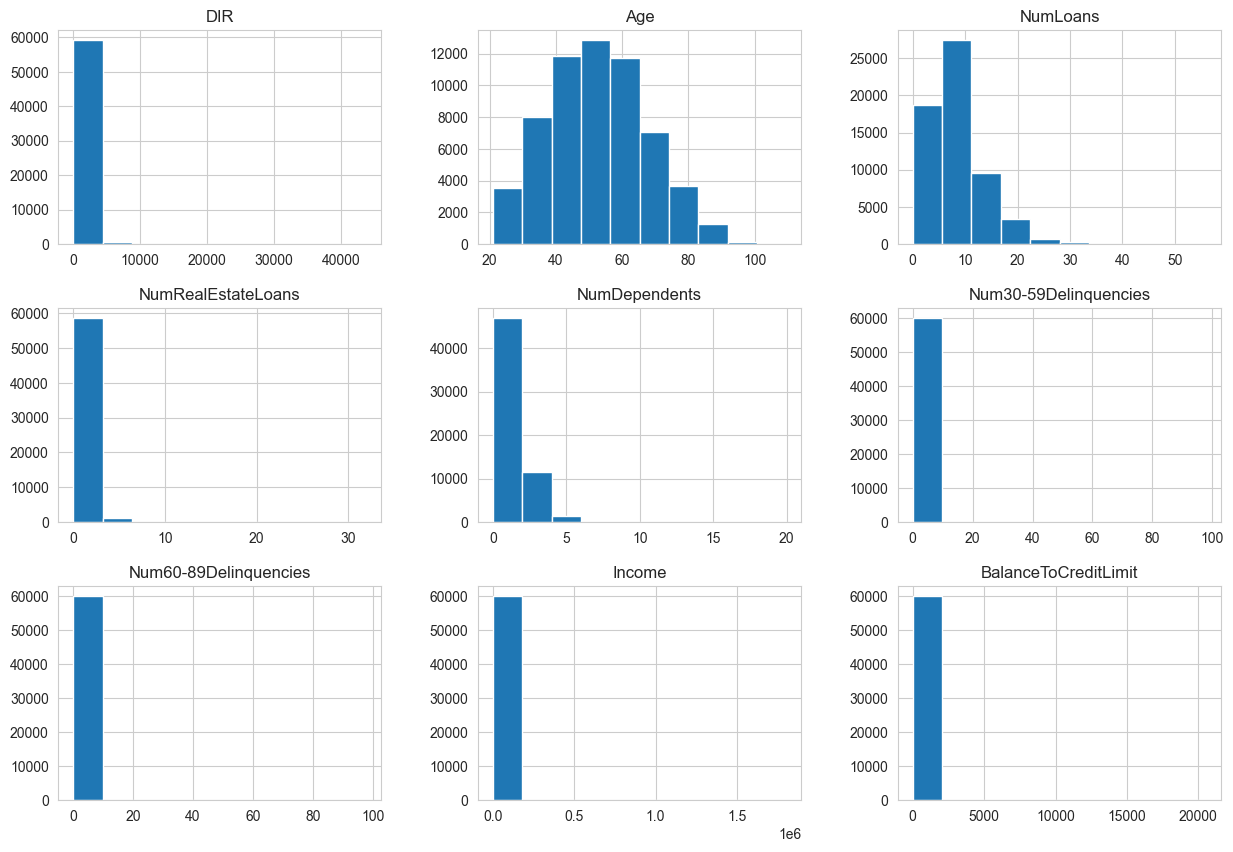

In [16]:
X_train.hist(figsize=(15, 10));

In [17]:
# sns.pairplot(X_train, hue='Delinquent90');

### Baseline

In [18]:
y_naive = np.random.choice([0, 1], size=y_test.shape[0], p=y_train.value_counts(normalize=True))

In [19]:
quality_report(y_naive, y_test)

Accuracy: 0.875
Precision: 0.062
Recall: 0.063
f1_score: 0.062


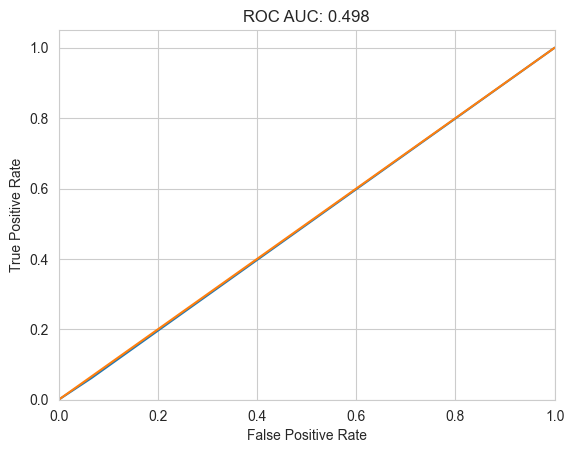

In [20]:
plot_roc_curve(y_naive, y_test)

### Дерево решений без настройки параметров

In [21]:
first_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
first_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [22]:
print("Train quality")
quality_report(first_tree.predict(X_train), y_train)

print("\nTest quality")
quality_report(first_tree.predict(X_test), y_test)

Train quality
Accuracy: 0.934
Precision: 0.047
Recall: 0.607
f1_score: 0.088

Test quality
Accuracy: 0.934
Precision: 0.050
Recall: 0.588
f1_score: 0.092


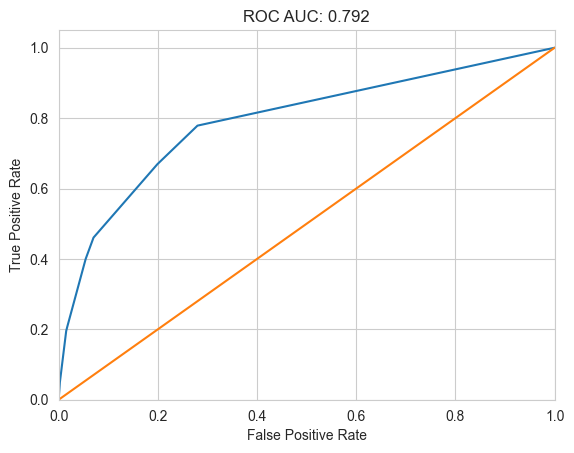

In [23]:
plot_roc_curve(first_tree.predict_proba(X_test)[:, 1], y_test)

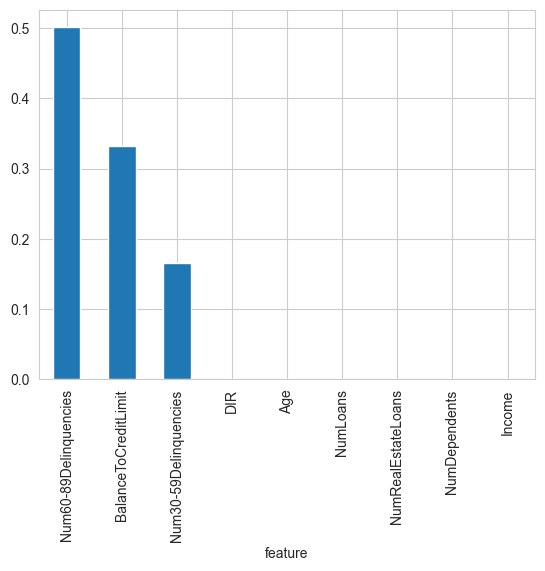

In [25]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": first_tree.feature_importances_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar');

**Прогноз для тестовой выборки.**

In [28]:
first_tree_pred = first_tree.predict(test_df)

In [29]:
np.bincount(first_tree_pred)

array([74608,   392])

**Запишем прогноз в файл.**

In [30]:
def write_to_submission_file(predicted_labels, out_file,
                             target='Delinquent90', index_label="client_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(75000, 
                                                  predicted_labels.shape[0] + 75000),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [31]:
first_tree_pred_probs = first_tree.predict_proba(test_df)[:, 1]

In [32]:
write_to_submission_file(first_tree_pred_probs, 'credit_scoring_first_tree_prob.csv')

## Дерево решений с настройкой параметров с помощью GridSearch

In [33]:
tree_params = {
               'max_depth': list(range(3,11)), 
               'min_samples_leaf': list(range(3,11)),
               'class_weight': [None, 'balanced']
}

locally_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                                 tree_params, 
                                 verbose=True, n_jobs=-1, cv=5,
                                scoring='roc_auc')

locally_best_tree.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='roc_auc', verbose=True)

In [35]:
locally_best_tree.best_params_, round(locally_best_tree.best_score_, 3)

({'class_weight': None, 'max_depth': 6, 'min_samples_leaf': 10}, 0.83)

In [36]:
quality_report(locally_best_tree.predict(X_test), y_test)

Accuracy: 0.933
Precision: 0.142
Recall: 0.497
f1_score: 0.220


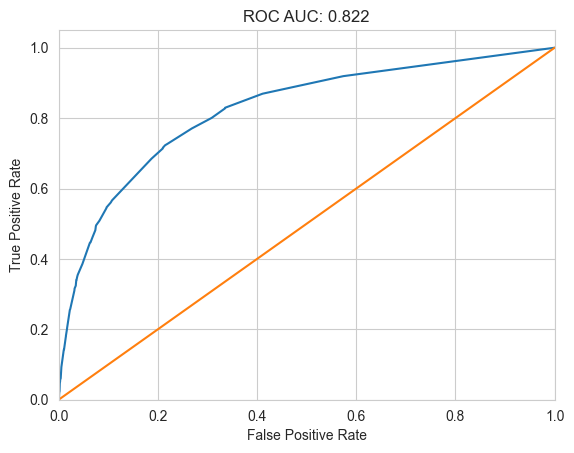

In [37]:
plot_roc_curve(locally_best_tree.predict_proba(X_test)[:, 1], y_test)

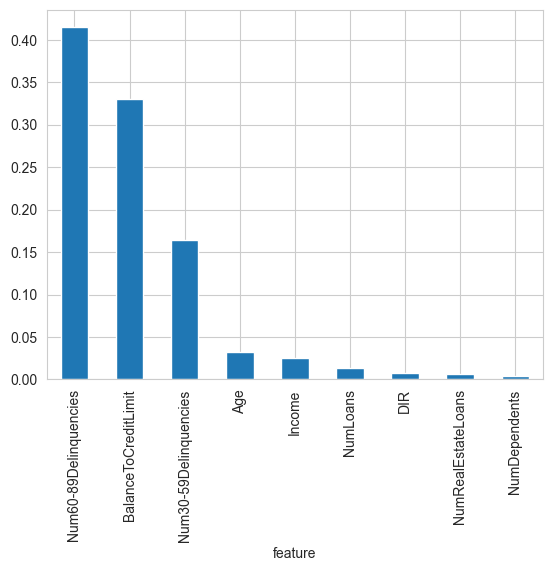

In [39]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": locally_best_tree.best_estimator_.feature_importances_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar');

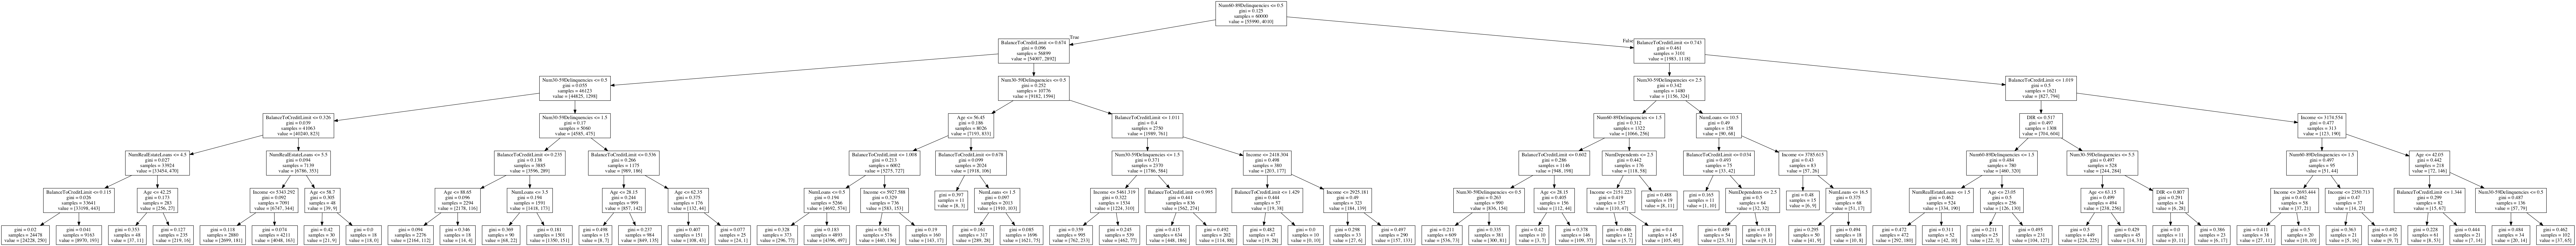

In [37]:
graph = Source(sklearn.tree.export_graphviz(
    locally_best_tree.best_estimator_, out_file=None, feature_names=X_train.columns))
png_bytes = graph.pipe(format='png')
with open('big_tree.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

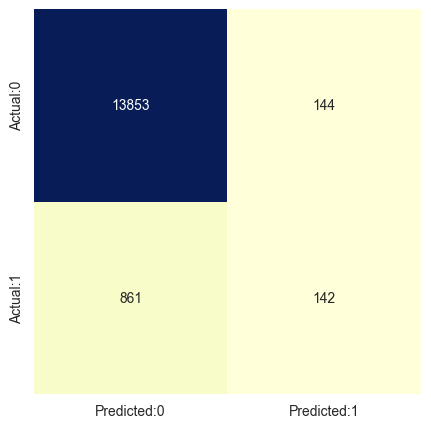

In [40]:
cm = confusion_matrix(y_test, locally_best_tree.predict(X_test))
conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
plt.figure(figsize = (5,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);